In [55]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [56]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [57]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [58]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

opt = keras.optimizers.Adam(learning_rate=0.01)
vae.compile(optimizer='adam')

In [59]:
# Define the Required Callback Function
import tensorflow as tf
class printlearningrate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR: {:.2f}'.format(lr))

def scheduler(epoch):
    optimizer = model.optimizer
    return K.eval(optimizer.lr + 0.01)

import keras
from keras.callbacks import ModelCheckpoint

class reduce_prints(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 ==0:
            print(f"Epoch {epoch}: Loss is: {logs['loss']}")

            
rp = reduce_prints()

printlr = printlearningrate() 


In [60]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

history_vae = vae.fit(x_train, x_train,
        epochs=200,
        batch_size=512,
        validation_data=(x_test, x_test), verbose = 0, callbacks = [rp])

Epoch 0: Loss is: 296.7514343261719
Epoch 10: Loss is: 166.11428833007812
Epoch 20: Loss is: 161.0265350341797
Epoch 30: Loss is: 158.7041473388672
Epoch 40: Loss is: 157.13702392578125
Epoch 50: Loss is: 155.95945739746094
Epoch 60: Loss is: 154.9869384765625
Epoch 70: Loss is: 154.1757354736328
Epoch 80: Loss is: 153.38426208496094
Epoch 90: Loss is: 152.75669860839844
Epoch 100: Loss is: 152.17544555664062
Epoch 110: Loss is: 151.68409729003906
Epoch 120: Loss is: 151.25132751464844
Epoch 130: Loss is: 150.842529296875
Epoch 140: Loss is: 150.43905639648438
Epoch 150: Loss is: 150.1436767578125
Epoch 160: Loss is: 149.78860473632812
Epoch 170: Loss is: 149.55967712402344
Epoch 180: Loss is: 149.3578643798828
Epoch 190: Loss is: 149.0511932373047


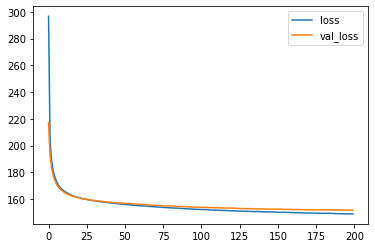

In [61]:
import matplotlib.pyplot as plt

plt.plot(history_vae.history['loss'])
plt.plot(history_vae.history['val_loss'])
plt.legend(['loss', 'val_loss'])

1    1135
2    1032
7    1028
dtype: int64


<AxesSubplot:>

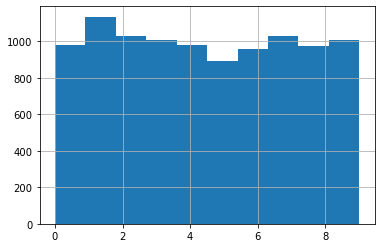

In [63]:
import pandas as pd

y_p = pd.Series(y_test)
print(y_p.value_counts().head(3))

y_p.hist()

 Total points to represent 10000


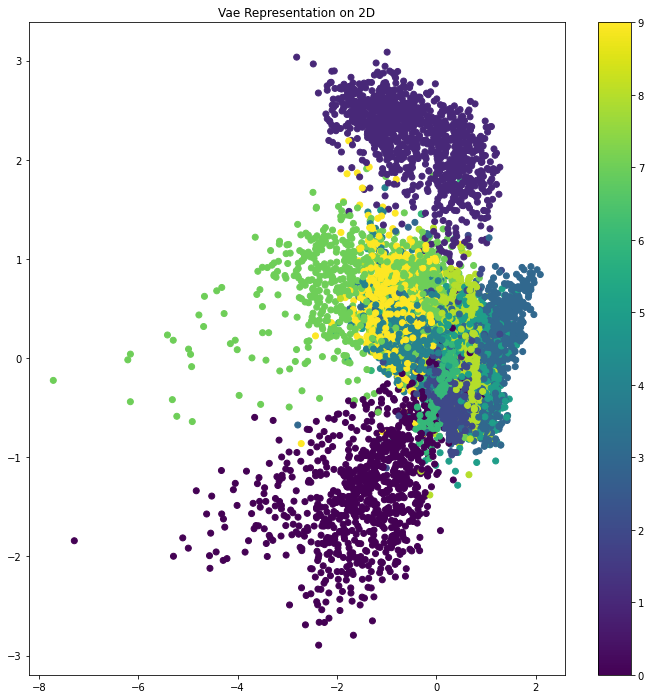

In [97]:
def create_VAE(cut_point: int = x_test.shape[0]):
    x_test_encoded = encoder.predict(x_test[:cut_point], batch_size=9)
    print(f" Total points to represent {x_test_encoded[0].shape[0]}")
    plt.figure(figsize=(12, 12))
    plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test[:cut_point])
    plt.colorbar()
    plt.title('Vae Representation on 2D')
    plt.show()
    

create_VAE()

shape of pca_reduced.shape =  (10000, 2)


C:\Users\f.gonzalez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


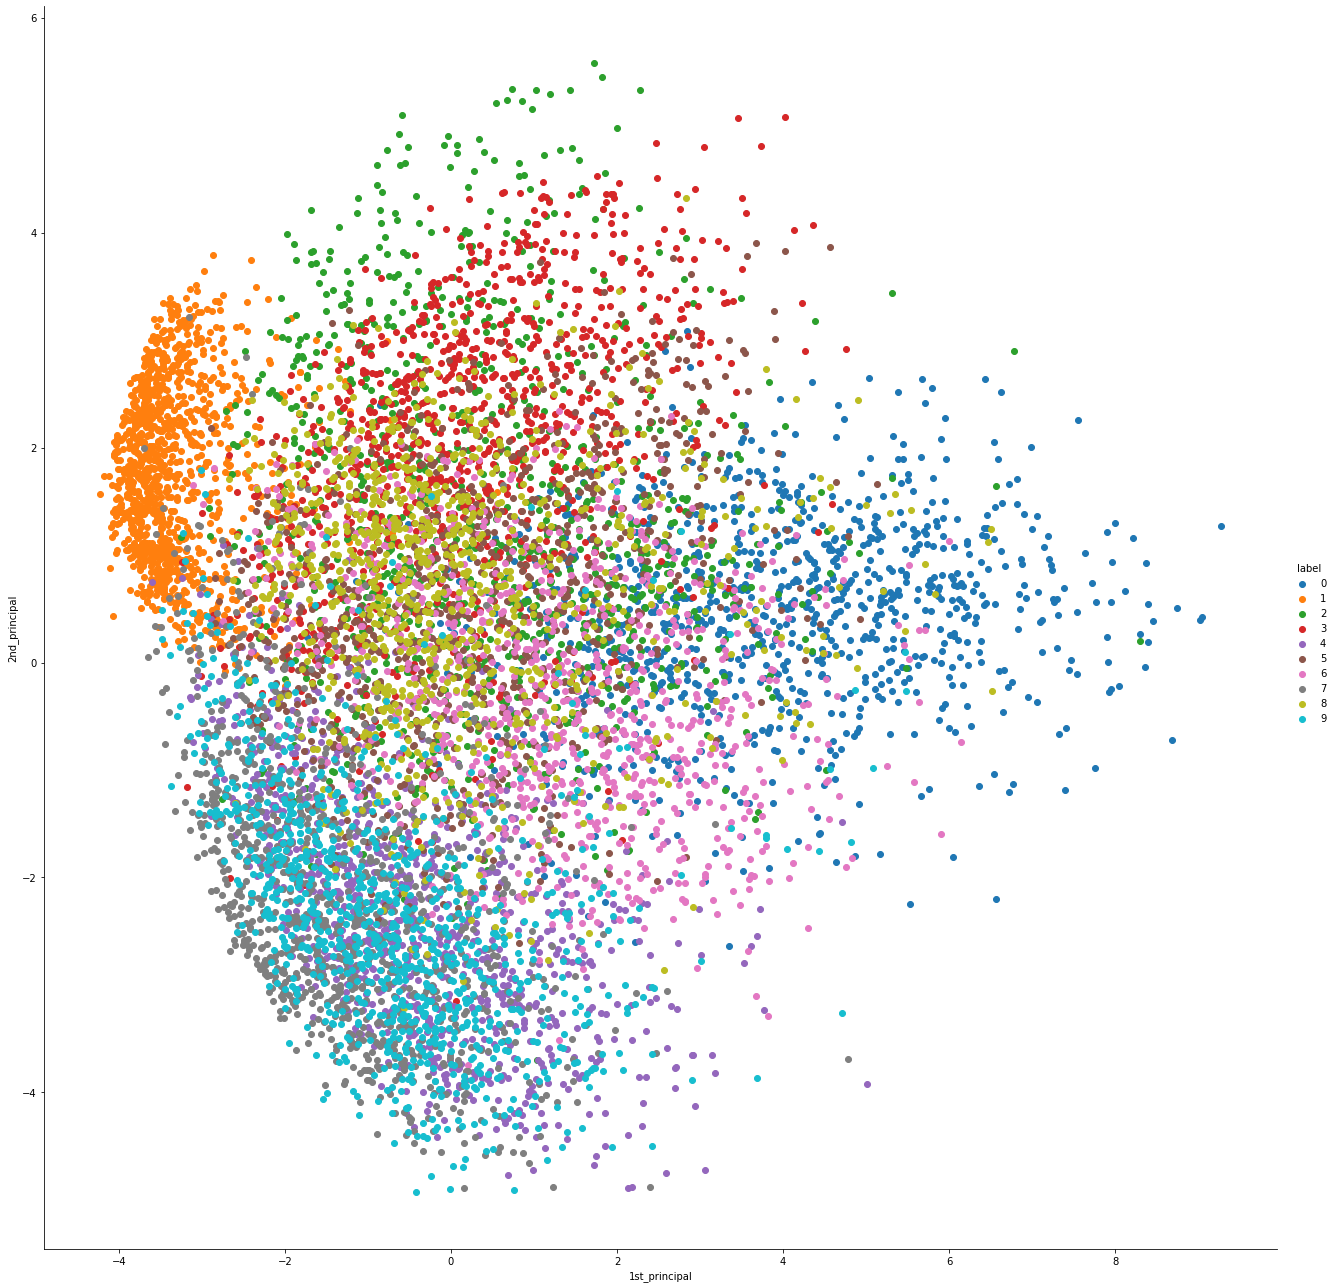

In [104]:
def create_PCA(cut_point: int = x_test.shape[0]):
    from sklearn import decomposition
    pca=decomposition.PCA()
    pca.n_components = 2
    pca_data = pca.fit_transform(x_test[:cut_point])
    print("shape of pca_reduced.shape = ", pca_data.shape)
    pca_data = np.vstack((pca_data.T, y_test[:cut_point])).T
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    pca_df["label"]  = pca_df["label"].astype(int)
    import seaborn as sns
    sns.FacetGrid(pca_df, hue="label", size=18).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.show()
    
create_PCA()

shape of pca_reduced.shape =  (2000, 2)


C:\Users\f.gonzalez\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


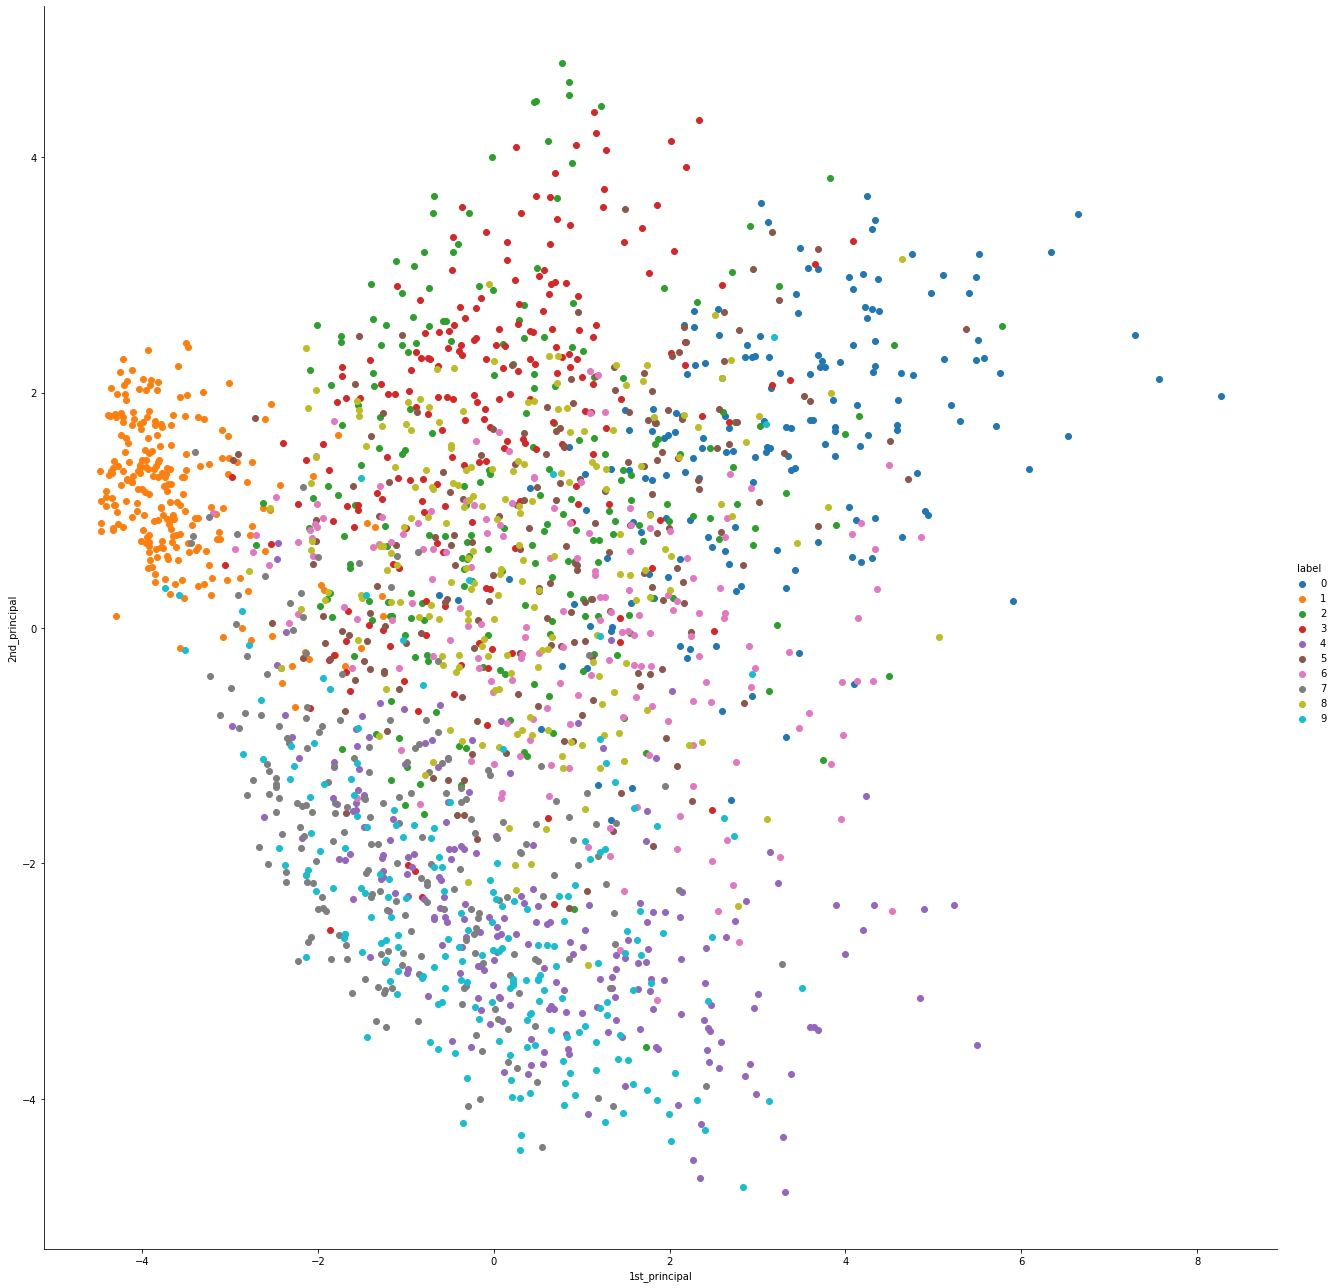

In [105]:
create_PCA(2000)

 Total points to represent 2000


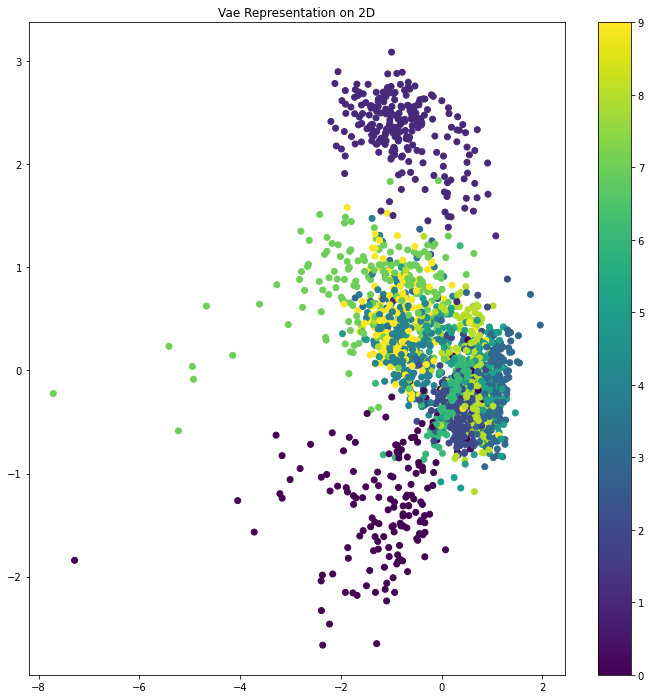

In [107]:
create_VAE(2000)

As we can see from the graphs above, when we are using the whole testing set is difficult to distinguish and see something clearly. But, when we use less samples to study the degree of separability we can see results from VAE are way better than with PCA. 
This might be because PCA assumes a linear relationship between features. The algorithm is not well suited to capturing non-linear relationships. That’s why it’s advised to turn non-linear features or relationships between features into linear, using the standard methods such as log transforms. So, maybe PCA is not a robust algorithm to be compared to.

SyntaxError: invalid syntax (<ipython-input-101-d3b3a119480a>, line 1)

In [31]:
import time
t0 = time.time()
time.sleep(2)

time.time() - t0

2.001986026763916

In [41]:
from keras.datasets import mnist
import numpy as np
import time
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


import matplotlib.pyplot as plt
for bs in [16, 32, 64, 128, 256]:
    t0 = time.time()
    vae = keras.Model(inputs, outputs, name='vae_mlp' + str(bs))
    vae.compile(optimizer='adam')
    history_vae = vae.fit(x_train, x_train,
            epochs=50,
            batch_size=bs,
            validation_data=(x_test, x_test), verbose = 0, callbacks = [])
    print(f" Time took to train model with bs = {bs}, {time.time() - t0}")
    plt.plot(history_vae.history['loss'])
    plt.plot(history_vae.history['val_loss'])
    plt.title(f"Batch size = {bs}")
    plt.legend(['loss', 'val_loss'])
    plt.show()

ValueError: in user code:

    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:598 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    C:\Users\f.gonzalez\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\utils.py:78 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0', 'dense_9/kernel:0', 'dense_9/bias:0', 'dense_10/kernel:0', 'dense_10/bias:0'].


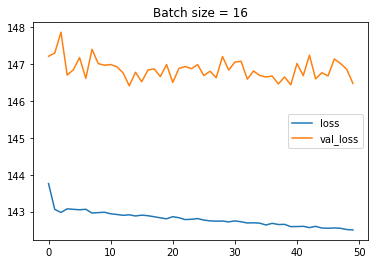

In [29]:
bs = 16
plt.plot(history_vae.history['loss'])
plt.plot(history_vae.history['val_loss'])
plt.title(f"Batch size = {bs}")
plt.legend(['loss', 'val_loss'])
plt.show()